
# Wine Quality Classification Project

## Pendahuluan
Proyek ini bertujuan untuk mengklasifikasikan kualitas wine menjadi dua kelas: **rendah (0)** dan **tinggi (1)** berdasarkan fitur-fitur kimia seperti kadar alkohol, keasaman, pH, dan lainnya. Dataset mencakup wine **merah** dan **putih** yang diambil dari [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine+quality).

## Tujuan
- Menganalisis distribusi kualitas wine berdasarkan jenisnya (red/white).
- Menghadapi permasalahan data imbalance antara label kualitas rendah dan tinggi.
- Membangun model klasifikasi yang akurat menggunakan algoritma Random Forest.
- Meningkatkan performa model dengan teknik oversampling (SMOTE) dan hyperparameter tuning.

## Alur Analisis
1. EDA dan preprocessing dataset
2. Deteksi dan penanganan data imbalance
3. Pelatihan dan tuning model
4. Evaluasi performa model
5. Visualisasi feature importance dan ROC Curve


# Wine Quality Classification Project

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve


### Data Loaded

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [2]:

# Load Datasets
red = pd.read_csv("winequality-red.csv", sep=';')
white = pd.read_csv("winequality-white.csv", sep=';')
red["type"], white["type"] = "red", "white"
df = pd.concat([red, white], axis=0)

In [3]:
# Binary target: 0 (low: 3–6), 1 (high: 7–9)
df['quality_label'] = df['quality'].apply(lambda q: 1 if q >= 7 else 0)


### Exploratory Data Analaysis Visualizations

Dari visualisasi distribusi kualitas wine berdasarkan jenisnya, terlihat adanya ketidakseimbangan jumlah antara kelas kualitas rendah (0) dan tinggi (1). Wine jenis putih memiliki dominasi jumlah sampel di kedua kelas, namun perbedaan sangat besar terjadi di kelas kualitas rendah. Sementara itu, wine merah memiliki jumlah sampel yang jauh lebih sedikit, khususnya pada kelas kualitas tinggi. Hal ini mengindikasikan bahwa dataset ini termasuk **imbalanced classification problem**, yang berpotensi memengaruhi performa model. Oleh karena itu, perlu dilakukan penanganan imbalance seperti **SMOTE** pada tahap preprocessing.


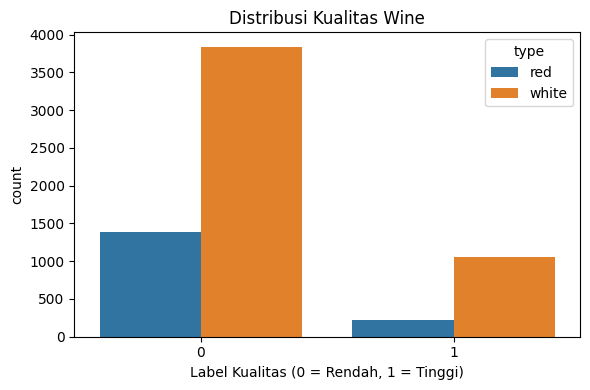

In [4]:
# ==== Exploratory Data Analysis (EDA) ====
# Distribusi label
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', hue='type', data=df)
plt.title("Distribusi Kualitas Wine")
plt.xlabel("Label Kualitas (0 = Rendah, 1 = Tinggi)")
plt.tight_layout()
plt.show()


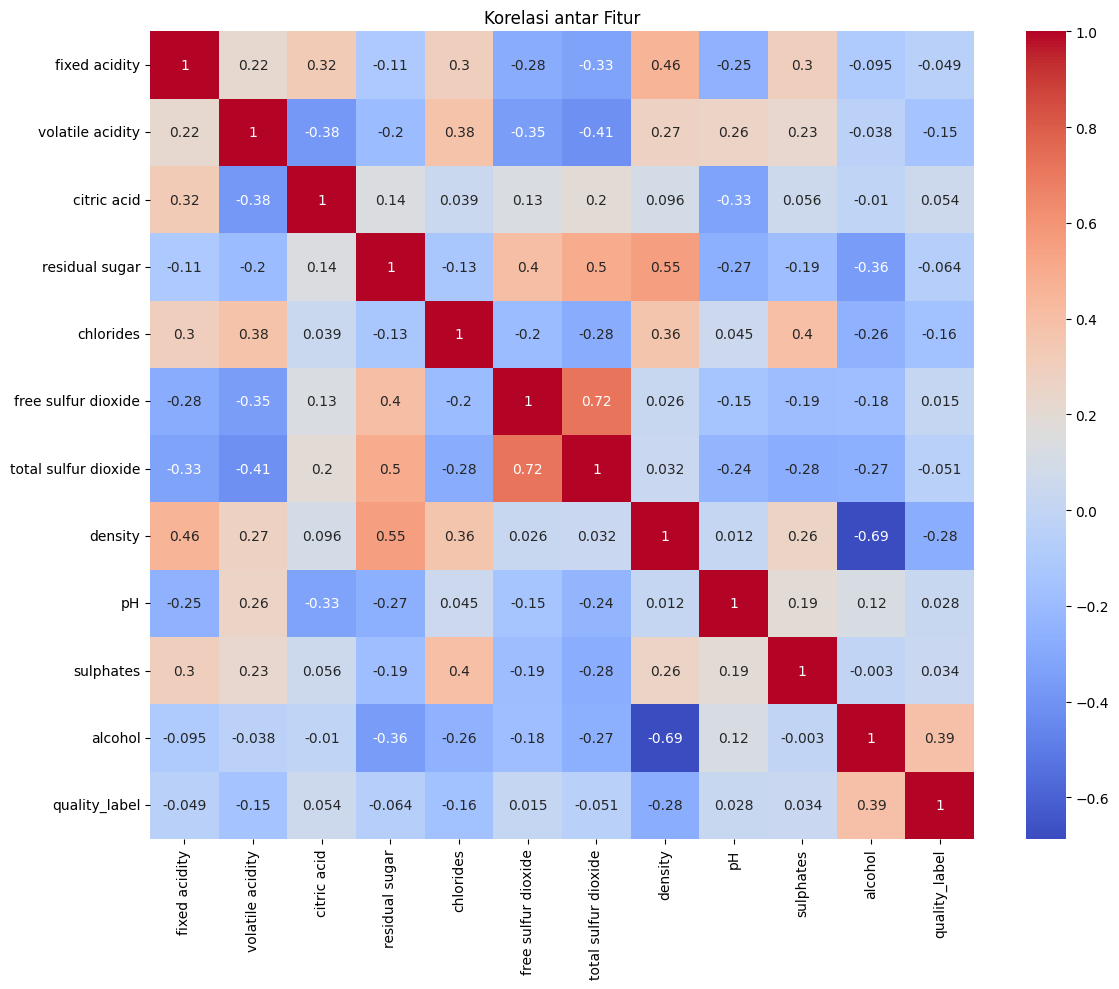

In [5]:
# Korelasi fitur
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(['quality', 'type'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar Fitur")
plt.tight_layout()
plt.show()

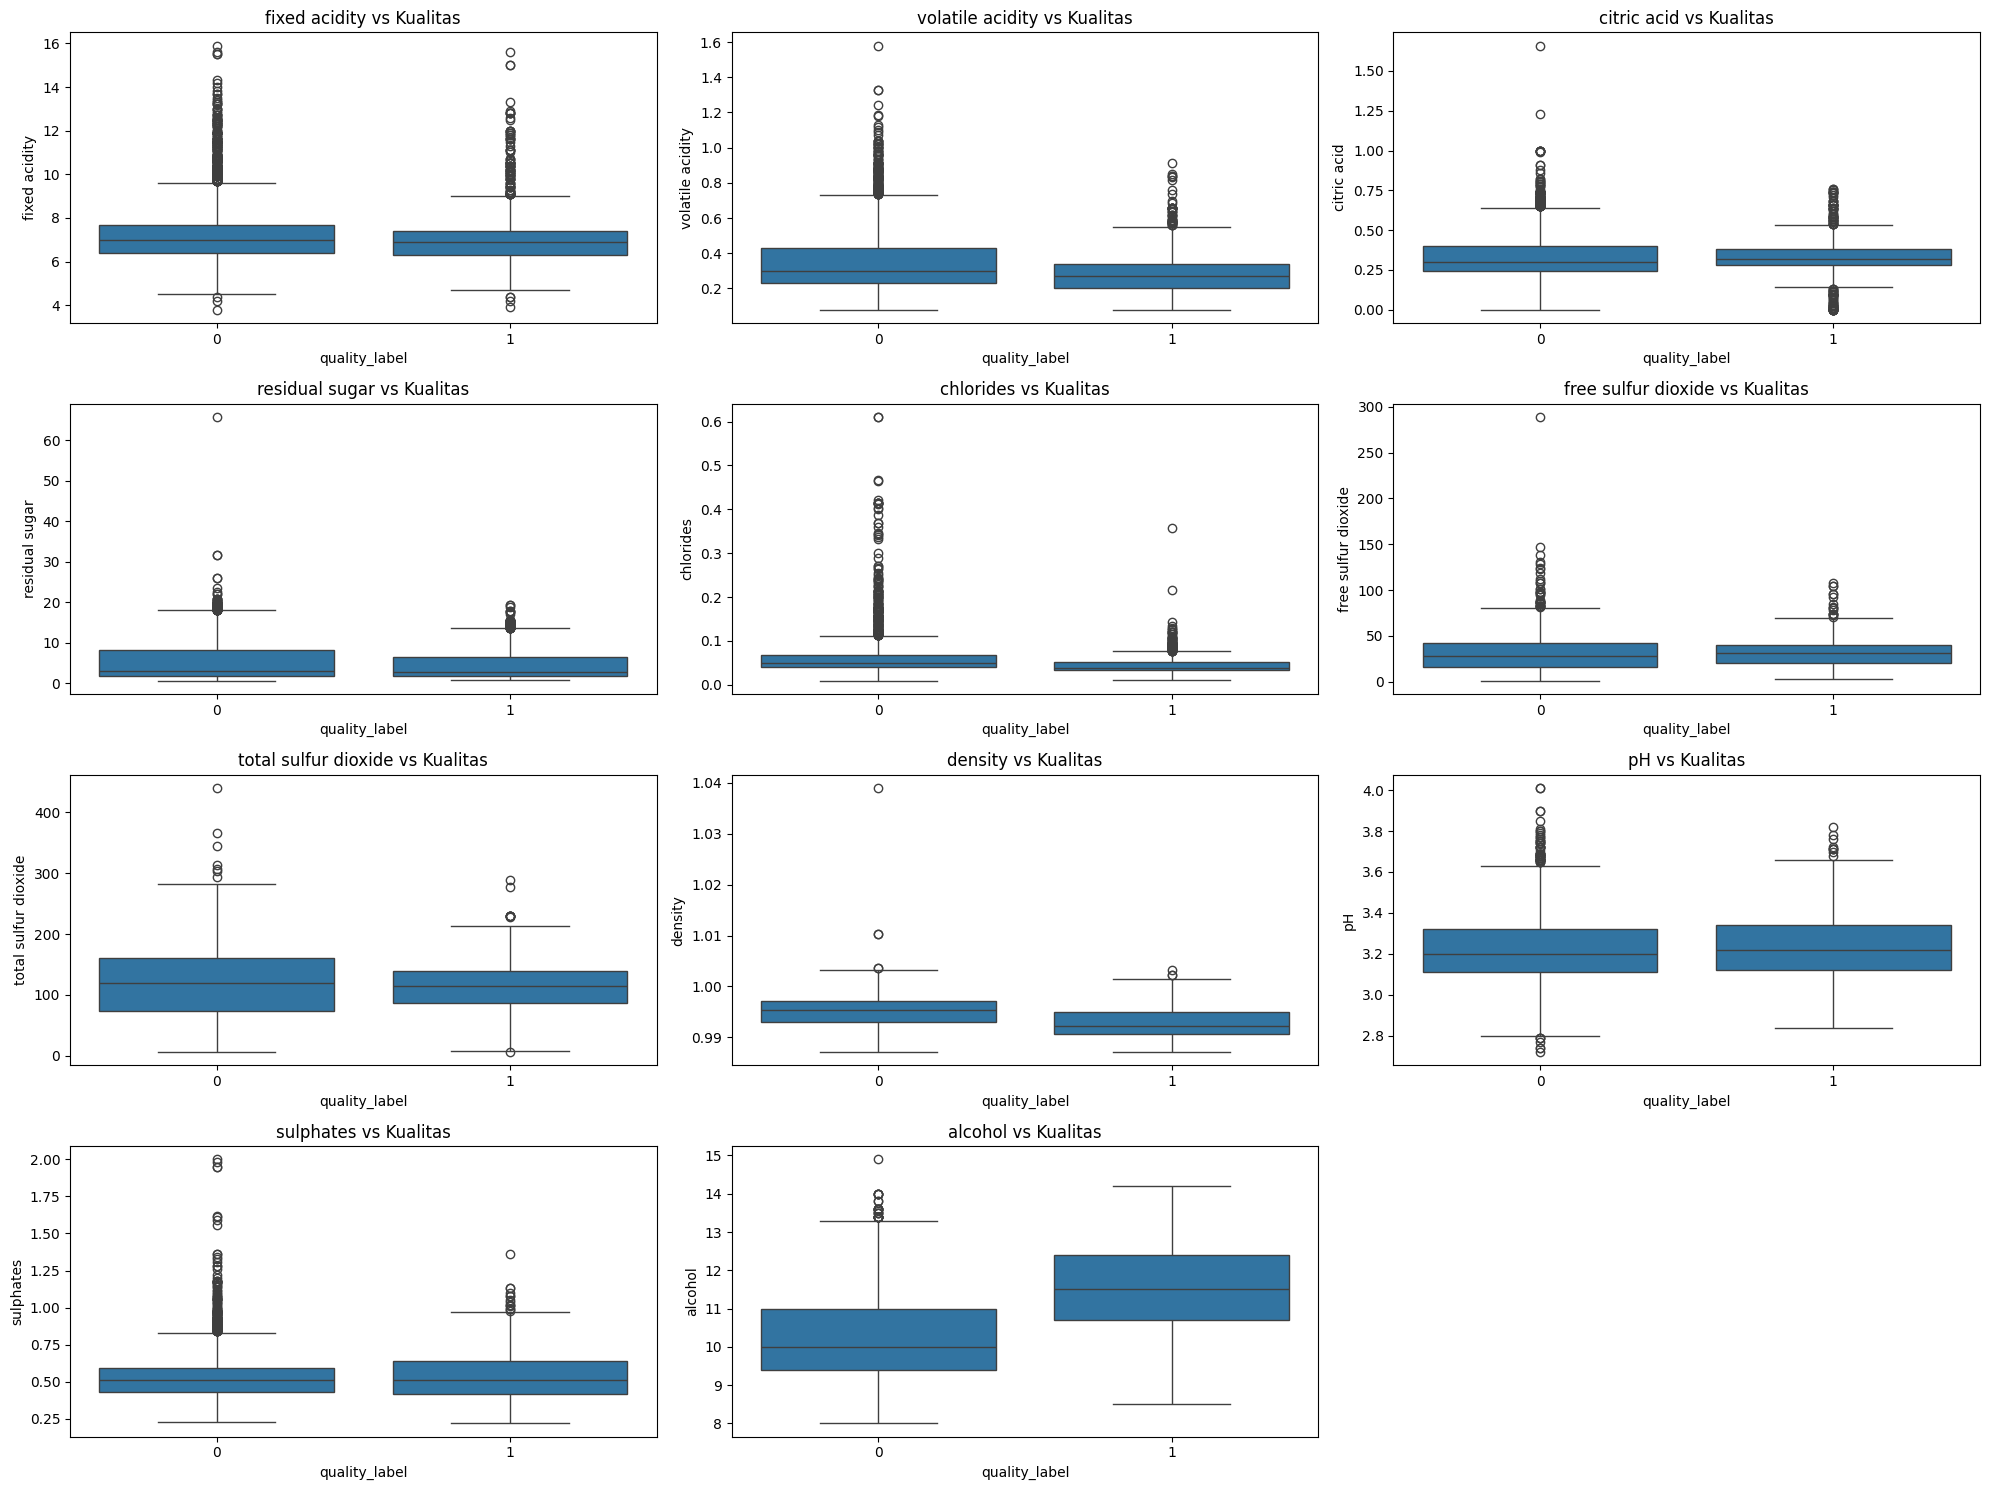

In [6]:
# Boxplot sebelum outlier removal
features = df.columns[:-3]
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='quality_label', y=feature, data=df)
    plt.title(f"{feature} vs Kualitas")
plt.tight_layout()
plt.show()

In [7]:
# ==== Outlier Removal ====
def remove_outliers(df, features):
    df_clean = df.copy()
    for feature in features:
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[feature] >= lower_bound) & (df_clean[feature] <= upper_bound)]
    return df_clean

df_clean = remove_outliers(df, features)

In [8]:
# ==== Preprocessing ====
X = df_clean.drop(['quality', 'quality_label', 'type'], axis=1)
y = df_clean['quality_label']

In [9]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


In [10]:

# ==== SMOTE ====
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)


## Modeling

In [11]:
## Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_smote, y_train_smote)
print("DT Accuracy:", accuracy_score(y_test, dt.predict(X_test_scaled)))


DT Accuracy: 0.8228260869565217


In [12]:
## Random Forest (Randomized Search)
rf = RandomForestClassifier(random_state=42)
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
rf_search = RandomizedSearchCV(rf, param_rf, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
rf_search.fit(X_train_smote, y_train_smote)
rf_best = rf_search.best_estimator_
print("Random Forest (Tuned) Accuracy:", accuracy_score(y_test, rf_best.predict(X_test_scaled)))


Random Forest (Tuned) Accuracy: 0.8673913043478261


In [13]:
## SVM (Grid Search)
svm = SVC(probability=True)
svm_param = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01]}
svm_search = GridSearchCV(svm, svm_param, cv=5, scoring='accuracy', n_jobs=-1)
svm_search.fit(X_train_smote, y_train_smote)
svm_best = svm_search.best_estimator_
print("SVM Accuracy:", accuracy_score(y_test, svm_best.predict(X_test_scaled)))


SVM Accuracy: 0.8108695652173913


In [14]:
## XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb.predict(X_test_scaled)))


XGBoost Accuracy: 0.8576086956521739


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:11:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Low Quality", "High Quality"]).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()



===== Decision Tree =====
Accuracy: 0.8228260869565217
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       725
           1       0.56      0.75      0.64       195

    accuracy                           0.82       920
   macro avg       0.74      0.80      0.76       920
weighted avg       0.85      0.82      0.83       920



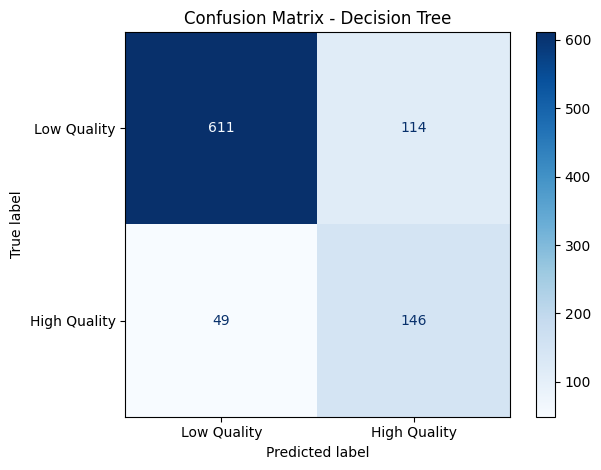


===== Random Forest =====
Accuracy: 0.8673913043478261
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       725
           1       0.66      0.76      0.71       195

    accuracy                           0.87       920
   macro avg       0.80      0.83      0.81       920
weighted avg       0.88      0.87      0.87       920



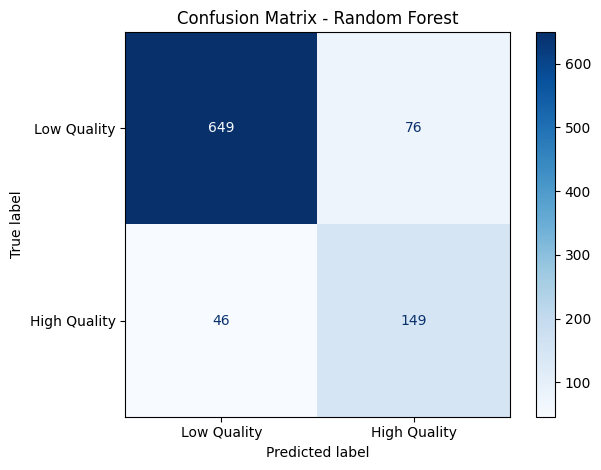


===== SVM =====
Accuracy: 0.8108695652173913
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87       725
           1       0.54      0.75      0.63       195

    accuracy                           0.81       920
   macro avg       0.73      0.79      0.75       920
weighted avg       0.84      0.81      0.82       920



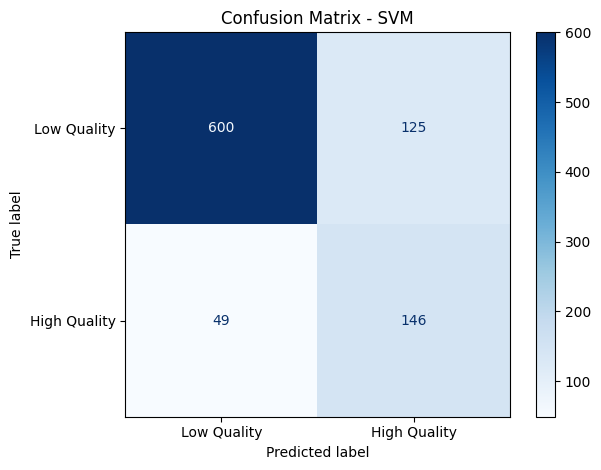


===== XGBoost =====
Accuracy: 0.8576086956521739
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       725
           1       0.65      0.71      0.68       195

    accuracy                           0.86       920
   macro avg       0.79      0.80      0.79       920
weighted avg       0.86      0.86      0.86       920



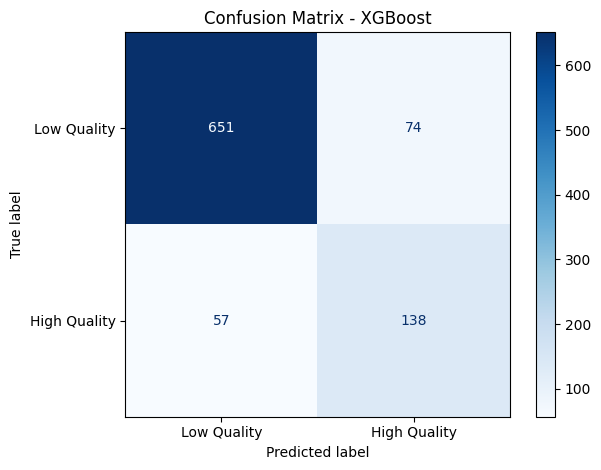

In [17]:
evaluate_model("Decision Tree", dt, X_test_scaled, y_test)
evaluate_model("Random Forest", rf_best, X_test_scaled, y_test)
evaluate_model("SVM", svm_best, X_test_scaled, y_test)
evaluate_model("XGBoost", xgb, X_test_scaled, y_test)


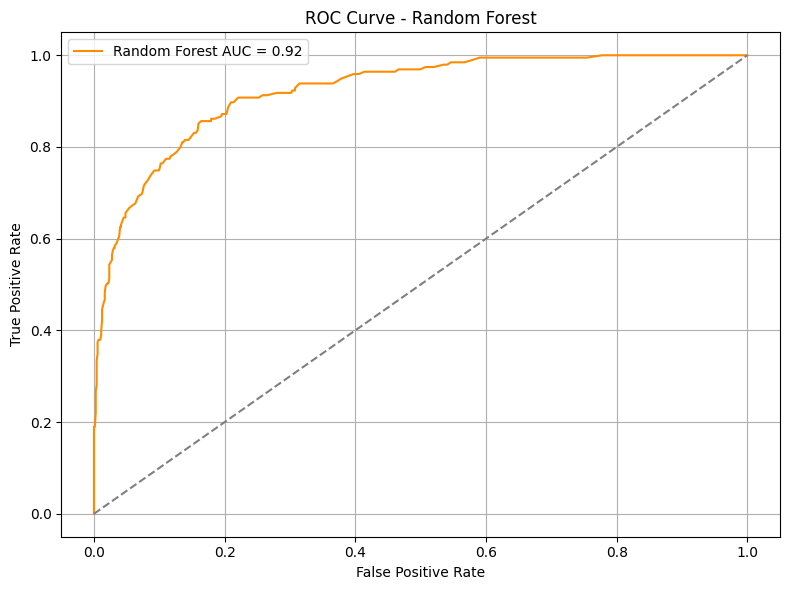

In [18]:
# ==== ROC Curve (Random Forest) ====
y_proba_rf = rf_best.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
